In [1]:
from ISLP import load_data
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
college = load_data('College')
df = college.copy()

In [3]:
y = df['Apps']
X = df.drop(columns=['Apps'])

In [8]:
# Convert categorical columns to numeric (e.g., Private -> 0/1)
X = pd.get_dummies(X, drop_first=True)

# Standardize numeric predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [9]:
lr = LinearRegression()
sfs_forward = SFS(lr, 
                  k_features='best', 
                  forward=True, 
                  floating=False, 
                  scoring='neg_mean_squared_error',
                  cv=5)
sfs_forward = sfs_forward.fit(X, y)

print("Forward Selection Best Features:")
print(list(sfs_forward.k_feature_names_))

Forward Selection Best Features:
['Accept', 'Top10perc', 'Outstate', 'Room.Board', 'PhD', 'S.F.Ratio', 'Expend', 'Grad.Rate']


In [12]:
alphas = np.logspace(-3, 3, 100)
ridge_cv = RidgeCV(alphas=alphas, store_cv_results=True)
ridge_cv.fit(X_scaled, y)
print(f"\nBest alpha for Ridge: {ridge_cv.alpha_}")
print(f"Ridge RMSE: {np.sqrt(mean_squared_error(y, ridge_cv.predict(X_scaled))):.2f}")


Best alpha for Ridge: 0.001
Ridge RMSE: 1029.21


In [13]:
lasso_cv = LassoCV(alphas=None, cv=5, max_iter=10000)
lasso_cv.fit(X_scaled, y)
lasso_coef = pd.Series(lasso_cv.coef_, index=X.columns)
print(f"\nBest alpha for Lasso: {lasso_cv.alpha_}")
print("Lasso Selected Features:")
print(lasso_coef[lasso_coef != 0])

c:\Users\Hi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1632: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(



Best alpha for Lasso: 11.1434986141217
Lasso Selected Features:
Accept         3721.093517
Enroll         -376.468368
Top10perc       733.367849
Top25perc      -156.851641
P.Undergrad      59.702470
Outstate       -292.365921
Room.Board      152.236155
Personal         12.053395
PhD            -117.686244
Terminal        -44.563066
S.F.Ratio        40.674783
perc.alumni      -7.119672
Expend          383.791103
Grad.Rate       116.128180
Private_Yes    -210.663108
dtype: float64


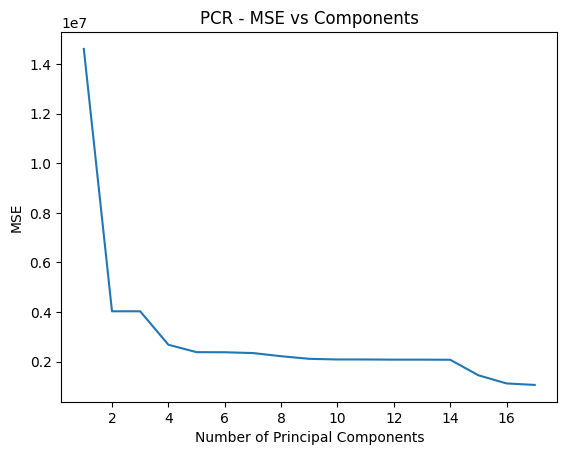


Best number of PCs: 17
PCR RMSE: 1029.21


In [14]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

mse = []
for i in range(1, X_pca.shape[1]+1):
    lr_pcr = LinearRegression()
    lr_pcr.fit(X_pca[:, :i], y)
    y_pred = lr_pcr.predict(X_pca[:, :i])
    mse.append(mean_squared_error(y, y_pred))

plt.plot(range(1, len(mse)+1), mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('PCR - MSE vs Components')
plt.show()

best_pcs = np.argmin(mse) + 1
print(f"\nBest number of PCs: {best_pcs}")
print(f"PCR RMSE: {np.sqrt(min(mse)):.2f}")

In [15]:
print("\n--- Summary ---")
print(f"Forward Selection chose {len(sfs_forward.k_feature_names_)} features.")
print(f"Lasso chose {sum(lasso_coef != 0)} features.")
print("→ Ridge uses all features (since it shrinks coefficients, not eliminate them).")
print("→ PCR reduces dimensionality, using only top principal components.")

print("\n✅ Conclusion:")
print("The best model depends on cross-validation MSE, but Lasso often gives a sparse model.")
print("Hence, not all features are required — Lasso and PCR automatically reduce dimensions.")



--- Summary ---
Forward Selection chose 8 features.
Lasso chose 15 features.
→ Ridge uses all features (since it shrinks coefficients, not eliminate them).
→ PCR reduces dimensionality, using only top principal components.

✅ Conclusion:
The best model depends on cross-validation MSE, but Lasso often gives a sparse model.
Hence, not all features are required — Lasso and PCR automatically reduce dimensions.
